# 1. 데이터 준비와 확인

In [1]:
import pandas as pd

train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터 로더 구성

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [3]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = { index: word for word, index in word_to_index.items() }

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델 구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

최대: 116
최소: 0
평균: 15.96940191154864


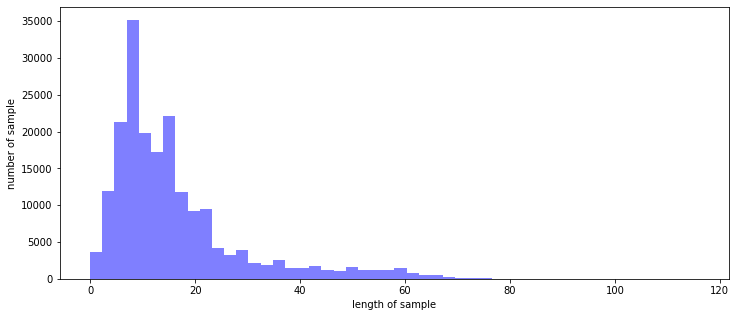

In [6]:
import matplotlib.pyplot as plt
import numpy as np

total = list(map(lambda it: len(it), X_train + X_test))
max_len = np.max(total)
print(f'최대: {max_len}')
print(f'최소: {np.min(total)}')
print(f'평균: {np.mean(total)}')

plt.figure(figsize = (12,5))
plt.hist(total, bins=50, alpha=0.5, color="b")
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

In [7]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=max_len)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=max_len)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((146182, 116), (146182,), (49157, 116), (49157,))

# 4. 모델 구성 및 validation set 구성

In [8]:
valid_split = round(len(X_train) * 0.2)

# validation set 10000건 분리
x_val = X_train[:valid_split]   
y_val = y_train[:valid_split]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[valid_split:]  
partial_y_train = y_train[valid_split:]

print(partial_x_train.shape, x_val.shape)
print(partial_y_train.shape, y_val.shape)

(116946, 116) (29236, 116)
(116946,) (29236,)


In [9]:
vocab_size = len(word_to_index)
word_vector_dim = 128

In [10]:
models = []

## 4-1. DNN

In [11]:
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(tf.keras.layers.Dense(64, activation='relu'))
model_1.add(tf.keras.layers.Dense(64, activation='relu'))
model_1.add(tf.keras.layers.Dense(8, activation='relu'))
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

models.append(model_1)

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
dense (Dense)                (None, None, 64)          8256      
_________________________________________________________________
dense_1 (Dense)              (None, None, 64)          4160      
_________________________________________________________________
dense_2 (Dense)              (None, None, 8)           520       
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           9         
Total params: 1,292,945
Trainable params: 1,292,945
Non-trainable params: 0
_________________________________________________________________


# 4-2. LSTM

In [12]:
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.LSTM(64))
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

models.append(model_2)

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,329,937
Trainable params: 1,329,937
Non-trainable params: 0
_________________________________________________________________


## 4-3. CNN

In [13]:
model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model_3.add(tf.keras.layers.MaxPooling1D(5))
model_3.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

models.append(model_3)

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          57408     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

## 4-4. CNN + LSTM

In [14]:
model_4 = tf.keras.Sequential()
model_4.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_4.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model_4.add(tf.keras.layers.MaxPooling1D(5))
model_4.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model_4.add(tf.keras.layers.MaxPooling1D(5))
model_4.add(tf.keras.layers.LSTM(64))
model_4.add(tf.keras.layers.Dense(8, activation='relu'))
model_4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

models.append(model_4)

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          57408     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

## 4-5. GMP

In [15]:
model_5 = tf.keras.Sequential()
model_5.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_5.add(tf.keras.layers.GlobalMaxPooling1D())
model_5.add(tf.keras.layers.Dense(8, activation='relu'))
model_5.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

models.append(model_5)

model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,281,041
Trainable params: 1,281,041
Non-trainable params: 0
_________________________________________________________________


# 5. 모델 훈련 개시

In [16]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
histories = []
epochs = 20

for model in models:
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=0,
                        callbacks=[early_stopping])
    histories.append(history)

# 6. Loss, Accuracy 그래프 시각화

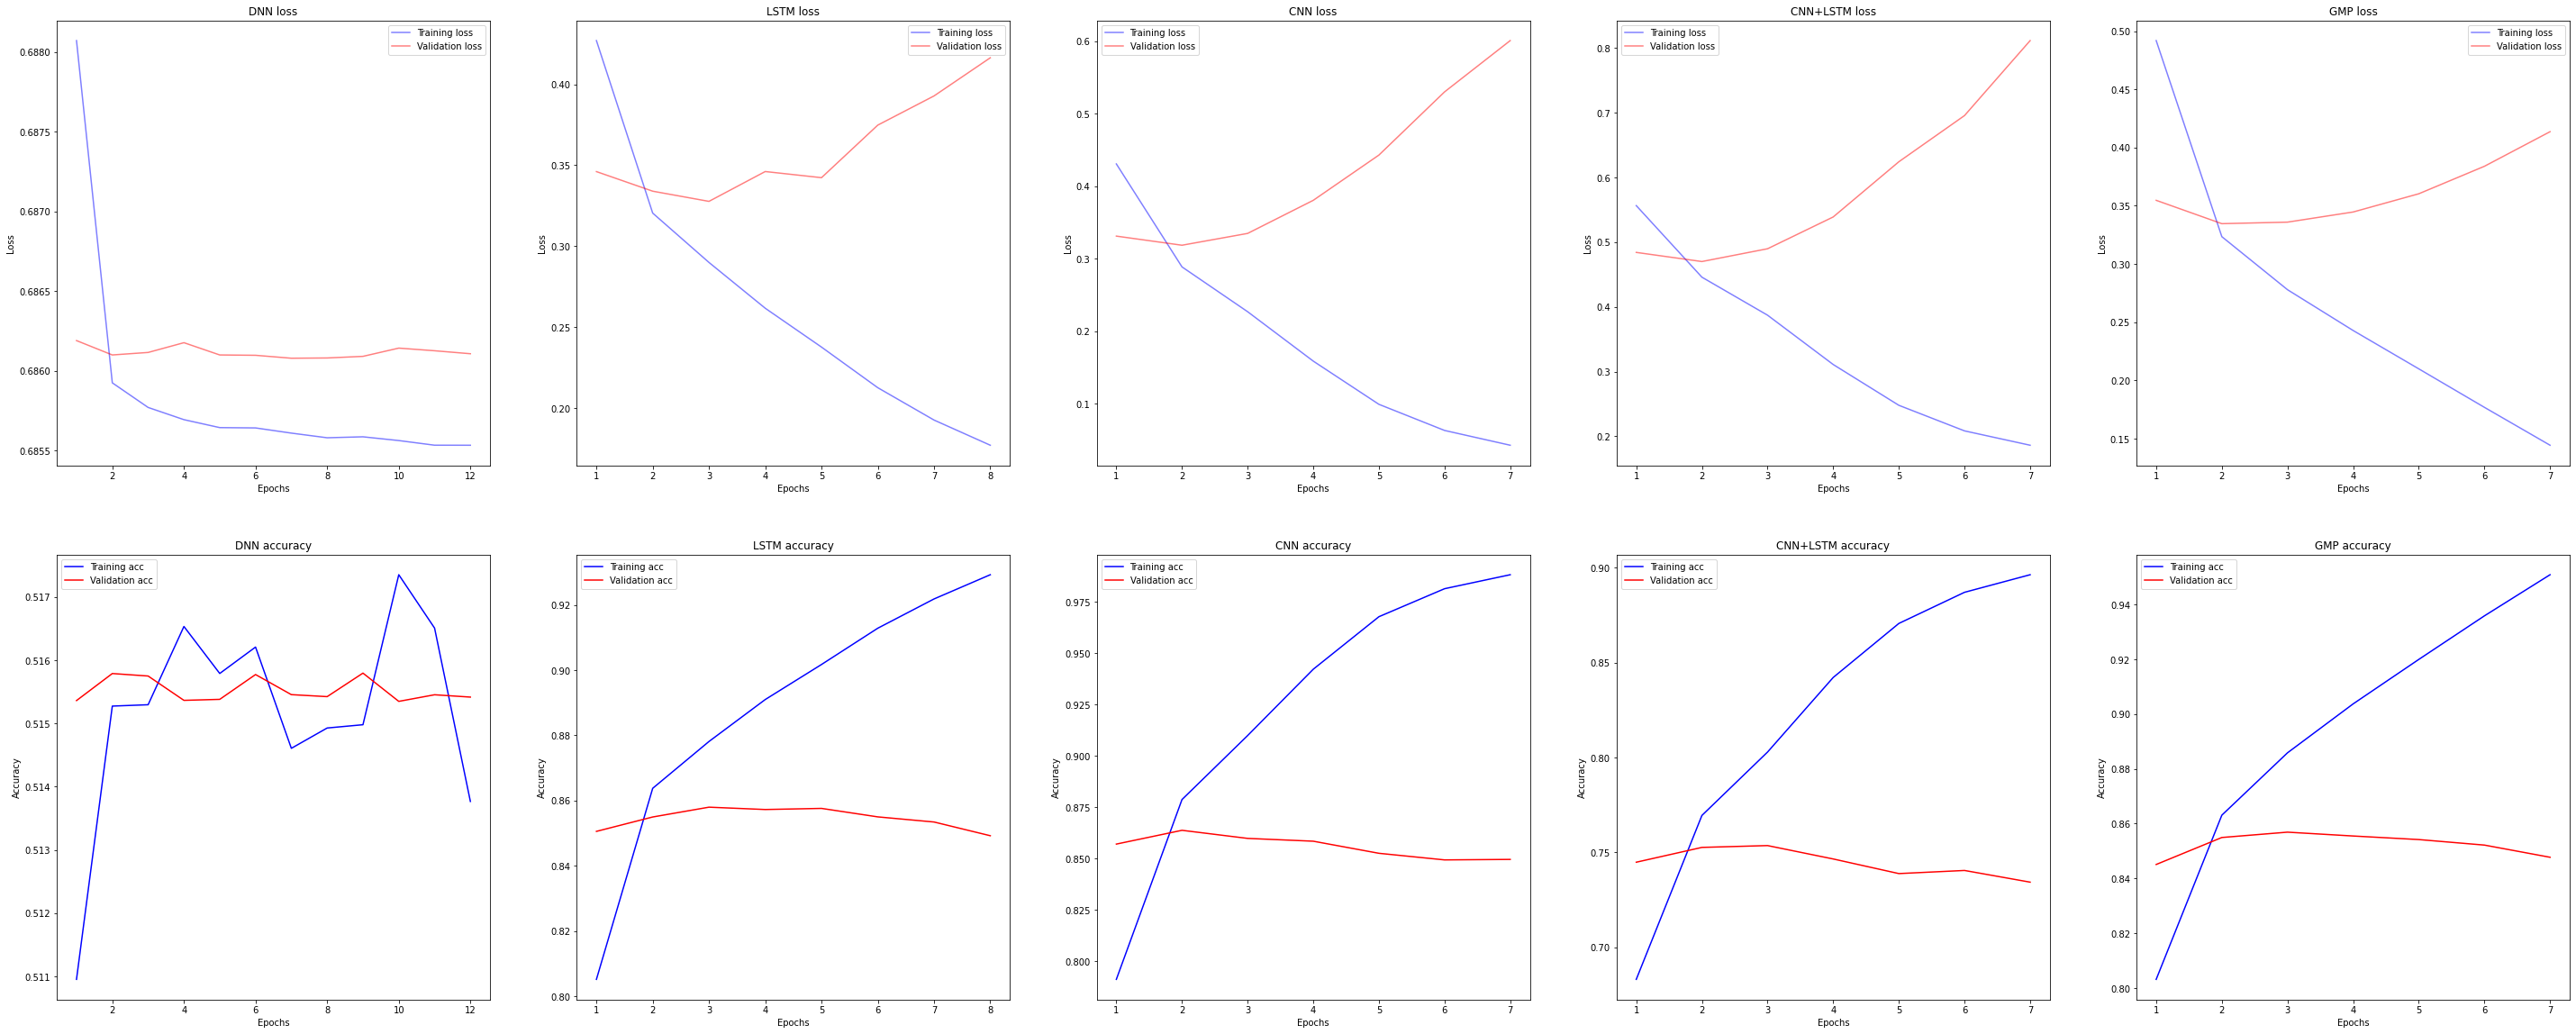

In [38]:
fig, ax = plt.subplots(2, len(models), figsize=(50, 20))

for index, model_name in enumerate(['DNN', 'LSTM', 'CNN', 'CNN+LSTM', 'GMP']):
    history = histories[index].history
    
    epochs = range(1, len(history['loss']) + 1)
    
    ax[0][index].plot(epochs, history['loss'], 'b', alpha=0.5, label='Training loss')
    ax[0][index].plot(epochs, history['val_loss'], 'r', alpha=0.5, label='Validation loss')
    ax[0][index].set_title(f'{model_name} loss')
    ax[0][index].set_xlabel('Epochs')
    ax[0][index].set_ylabel('Loss')
    ax[0][index].legend()
    
    ax[1][index].plot(epochs, history['accuracy'], 'b', label='Training acc')
    ax[1][index].plot(epochs, history['val_accuracy'], 'r', label='Validation acc')
    ax[1][index].set_title(f'{model_name} accuracy')
    ax[1][index].set_xlabel('Epochs')
    ax[1][index].set_ylabel('Accuracy')
    ax[1][index].legend()
    
plt.show()

# 7. 학습된 Embedding 레이어 분석

In [40]:
for index, model_name in enumerate(['DNN', 'LSTM', 'CNN', 'CNN+LSTM', 'GMP']):
    embedding_layer = models[index].layers[0]
    weights = embedding_layer.get_weights()[0]
    print(weights.shape)
    
    word2vec_file_path = f'./data/word2vec_{model_name}.txt'
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
    
    vectors = models[index].get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()

(10000, 128)
(10000, 128)
(10000, 128)
(10000, 128)
(10000, 128)


In [47]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = []
for model_name in ['DNN', 'LSTM', 'CNN', 'CNN+LSTM', 'GMP']:
    word_vector = Word2VecKeyedVectors.load_word2vec_format(f'./data/word2vec_{model_name}.txt', binary=False)
    word_vectors.append(word_vector)

In [48]:
# DNN

word_vectors[0].similar_by_word("재미")

[('부탁', 0.5029821991920471),
 ('끝나', 0.48007458448410034),
 ('서기', 0.4619591534137726),
 ('쫌', 0.45654812455177307),
 ('나온다면', 0.44702786207199097),
 ('인데', 0.4416315257549286),
 ('견자단', 0.4389823079109192),
 ('에다가', 0.426203191280365),
 ('여자', 0.42458510398864746),
 ('에피소드', 0.41758134961128235)]

In [49]:
#LSTM

word_vectors[1].similar_by_word("재미")

[('치유', 0.7131854295730591),
 ('매우', 0.7004674673080444),
 ('노튼', 0.6943978667259216),
 ('이준', 0.684178352355957),
 ('하악', 0.683815598487854),
 ('앞서', 0.6738821268081665),
 ('.!!!', 0.6723013520240784),
 ('어우', 0.6636901497840881),
 ('용서', 0.6610060334205627),
 ('흐뭇', 0.6595878601074219)]

In [50]:
#CNN

word_vectors[2].similar_by_word("재미")

[('조화', 0.5042492151260376),
 ('붉', 0.481398344039917),
 ('박보영', 0.4672197103500366),
 ('한텐', 0.4474707245826721),
 ('영웅', 0.44384512305259705),
 ('소시', 0.4395236074924469),
 ('술', 0.43295371532440186),
 ('꾀', 0.4318465292453766),
 ('밀라요보비치', 0.4290168583393097),
 ('손오공', 0.42552950978279114)]

In [51]:
#CNN + LSTM

word_vectors[3].similar_by_word("재미")

[('영애', 0.3835170567035675),
 ('부부', 0.3487011790275574),
 ('준거', 0.33520981669425964),
 ('전두환', 0.33267033100128174),
 ('...................', 0.3185339570045471),
 ('특집', 0.3148382306098938),
 ('찾아본', 0.31469032168388367),
 ('암울', 0.31305772066116333),
 ('아휴', 0.31070467829704285),
 ('멤버', 0.3025897145271301)]

In [52]:
#GMP

word_vectors[4].similar_by_word("재미")

[('스타일', 0.49500954151153564),
 ('까지', 0.49004313349723816),
 ('감동', 0.48096567392349243),
 ('음', 0.4782223403453827),
 ('에이미', 0.47204017639160156),
 ('너무', 0.47060033679008484),
 ('저리', 0.4624439477920532),
 ('난다', 0.455176442861557),
 ('내용', 0.45451676845550537),
 ('의미', 0.4534740447998047)]

# 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [59]:
word2vec = Word2VecKeyedVectors.load('./data/word2vec_ko.model')

print(word2vec.wv.vectors.shape)

(302960, 100)


In [61]:
word2vec.wv.most_similar("재미")

[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]

In [64]:
word_vector_dim = word2vec.wv.vectors.shape[1]
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4, vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [66]:
from tensorflow.keras.initializers import Constant

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=max_len, 
                                 trainable=True))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 116, 100)          1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 110, 16)           11216     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 22, 16)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 16, 16)            1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [69]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/20
229/229 [==============================] - 3s 11ms/step - loss: 0.6190 - accuracy: 0.6355 - val_loss: 0.5106 - val_accuracy: 0.7529
Epoch 2/20
229/229 [==============================] - 2s 8ms/step - loss: 0.4632 - accuracy: 0.7841 - val_loss: 0.4373 - val_accuracy: 0.7991
Epoch 3/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3987 - accuracy: 0.8222 - val_loss: 0.3975 - val_accuracy: 0.8209
Epoch 4/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3582 - accuracy: 0.8448 - val_loss: 0.3773 - val_accuracy: 0.8342
Epoch 5/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3295 - accuracy: 0.8598 - val_loss: 0.3689 - val_accuracy: 0.8391
Epoch 6/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3079 - accuracy: 0.8702 - val_loss: 0.3615 - val_accuracy: 0.8428
Epoch 7/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2882 - accuracy: 0.8817 - val_loss: 0.3598 - val_accuracy: 0.8443
Epoch

In [71]:
model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.4056 - accuracy: 0.8415


[0.4056060314178467, 0.8415281772613525]

In [72]:
# 기존 CNN

models[2].evaluate(X_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.6295 - accuracy: 0.8425


[0.6295270919799805, 0.8424842953681946]